In [43]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={'axes.grid':False})
import cv2
import numpy as np
import georaster
import torch
import json
import os
from pytorch_utils.eval import read_model, flip
from nbutils import (thresh, score_pred, load_img, make_input_tensor, predict_on_file,
                     get_saliency_big, plot_poly)
from config import Config
from contextlib import redirect_stdout
%matplotlib inline

In [2]:
cfg_f = '../resnet34_1x1080_retrain.json'
with open(cfg_f, 'r') as f:
    cfg = json.load(f)
cfg = Config(**cfg)
# When we have satellite imagery & depth-mapping
# See end of file for attempt at using only imagery
model = read_model(cfg, 4)

In [44]:
testdir='../../Test/Inputs/'
rgb_test = [x for x in os.listdir(testdir) if "RGB" in x]
to_sal = lambda x: x[:-7] + 'SAL.npy'
idx = 0
sal = np.load(testdir+to_sal(rgb_test[idx]))
tif = georaster.MultiBandRaster(testdir+rgb_test[idx])
img = tif.r / 255.0

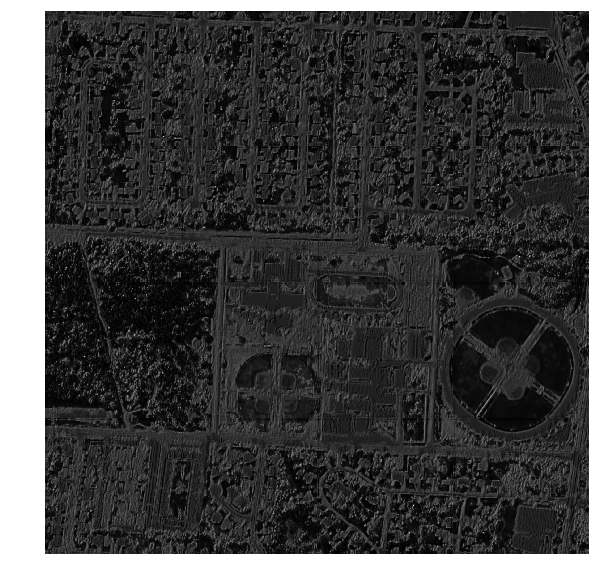

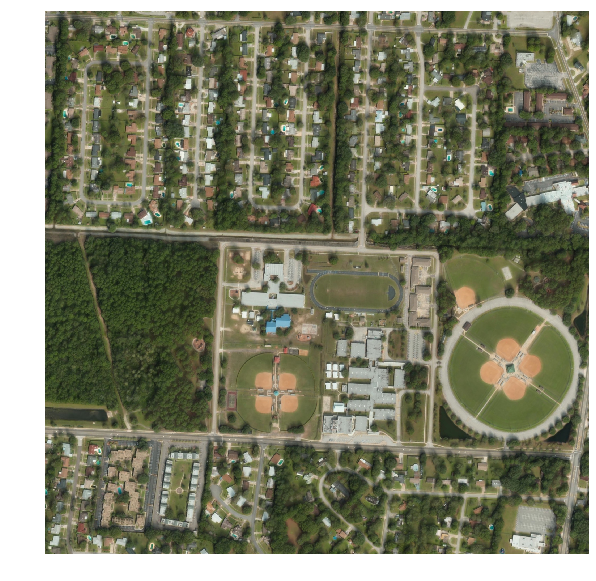

In [21]:
plt.figure(figsize=(10,10))
plt.imshow(sal*255,cmap='gray')
plt.axis('off')
plt.savefig("salmap-test")

plt.figure(figsize=(10,10))
plt.imshow(img)
plt.axis('off')
plt.savefig("rgb-test")

In [50]:
with torch.no_grad():
    output = model(torch.Tensor(make_input_tensor(img, sal)).cuda())
    output = output.cpu().numpy().squeeze()

/home/ngundotra/.conda/envs/gdal/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:129: UserWarning: nn.Upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.{} is deprecated. Use nn.functional.interpolate instead.".format(self.name))
/home/ngundotra/.conda/envs/gdal/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:129: UserWarning: nn.Upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.{} is deprecated. Use nn.functional.interpolate instead.".format(self.name))
/home/ngundotra/.conda/envs/gdal/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:129: UserWarning: nn.Upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.{} is deprecated. Use nn.functional.interpolate instead.".format(self.name))
/home/ngundotra/.conda/envs/gdal/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:129: UserWarning: nn.Upsample is deprecated. Use nn.functional.interpolate instead.
  war

In [56]:
get_ctr = lambda out: cv2.findContours(cv2.threshold(out, 127, 255, 0)[1].astype(np.uint8), 
                                           cv2.RETR_TREE,
                                           cv2.CHAIN_APPROX_SIMPLE)[1]

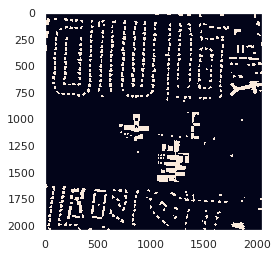

In [57]:
plt.imshow(cv2.threshold(output*255, 127, 255, 0)[1])

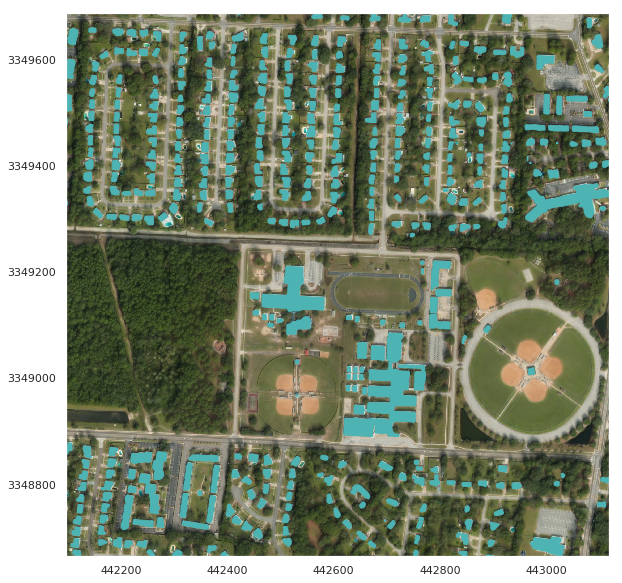

In [60]:
fig, ax = plt.subplots(figsize=(10,10), ncols=1, nrows=1)
ax.imshow(img, extent=tif.extent)
polys = get_ctr(output*255)
with open('georaster_issues.txt', 'w') as f:
    with redirect_stdout(f):
        plot_poly(polys, ax, tif.coordinates, color=(0.3, 0.7, 0.7))
plt.savefig("polygon-test")